# Multiband histogram matching with Rasterio and Scikit-image

In [1]:
# import packages
import rasterio as rio
from skimage.exposure import match_histograms

#plot functions
from rasterio.plot import show
from skimage import exposure
import matplotlib.pyplot as plt

In [2]:
# Open the Reference image
reference_path = r"C:\Users\andre\OneDrive - Politecnico di Milano\Earth_observation\project\Mod_b\imgs_elab\imgs_clip_by_extension_&_realign\2016_clipped_frame_alighed.tif"
with rio.open(reference_path, 'r+') as r:
    reference = r.read()
    metadata_reference = r.profile
    metadata_reference.update(compress='deflate')

In [3]:
# Open the Secondary image
secondary = r"C:\Users\andre\OneDrive - Politecnico di Milano\Earth_observation\project\Mod_b\imgs_elab\imgs_clip_by_extension_&_realign\2024_clipped_frame_alighed.tif"
with rio.open(secondary, 'r+') as s:
    secondary = s.read()
    metadata_secondary  = s.profile
    metadata_secondary.update(compress='deflate')
secondary

array([[[1469, 1513, 1645, ..., 2848, 2776, 3160],
        [1564, 1511, 1575, ..., 2078, 2282, 3164],
        [1750, 1769, 1778, ..., 2038, 1992, 2366],
        ...,
        [2002, 1920, 1986, ..., 3938, 3844, 2694],
        [2048, 1996, 1998, ..., 3480, 3132, 2606],
        [1982, 2002, 2016, ..., 2542, 2396, 2570]],

       [[1569, 1590, 1684, ..., 2688, 2764, 3104],
        [1593, 1556, 1574, ..., 1908, 2078, 2964],
        [1593, 1608, 1648, ..., 1864, 1804, 2284],
        ...,
        [1750, 1758, 1802, ..., 3644, 3610, 2656],
        [1806, 1762, 1813, ..., 3338, 3052, 2434],
        [1792, 1792, 1784, ..., 2398, 2320, 2406]],

       [[1367, 1434, 1510, ..., 2494, 2584, 2862],
        [1442, 1418, 1408, ..., 1767, 1916, 2810],
        [1454, 1434, 1510, ..., 1764, 1621, 2098],
        ...,
        [1558, 1552, 1566, ..., 3274, 3378, 2488],
        [1590, 1566, 1588, ..., 3108, 2746, 2170],
        [1554, 1600, 1601, ..., 2260, 2150, 2284]]], dtype=uint16)

In [4]:
# Match histogram of each band and store the result in a new raster band
file_list = []
for band in range(0, secondary.shape[0]):

    secondary_rescale = match_histograms(secondary[band], reference[band], channel_axis=-1)
    file_path = r"C:\Users\andre\OneDrive - Politecnico di Milano\Earth_observation\project\Mod_b\imgs_elab\histogram_matching_supports\match_sup"+str(band)+".tif"
    file_list.append(file_path)

    with rio.open(file_path, 'w', **metadata_secondary) as dstBand:
        metadata_dstBand = dstBand.profile
        metadata_dstBand.update(count=1)
        dstBand.write(secondary_rescale.astype(metadata_secondary['dtype']),1)

In [5]:
# Create a multiband raster with matched bands
with rio.open(file_list[0]) as src0:
    meta = src0.meta

# Update metadata to reflect the number of bands
meta.update(count = len(file_list))

# Read each band and write it to a stack
secondary_matched_path = r"C:\Users\andre\OneDrive - Politecnico di Milano\Earth_observation\project\Mod_b\imgs_elab\histogram_matching_supports\match_sup.tif"
with rio.open(secondary_matched_path, 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

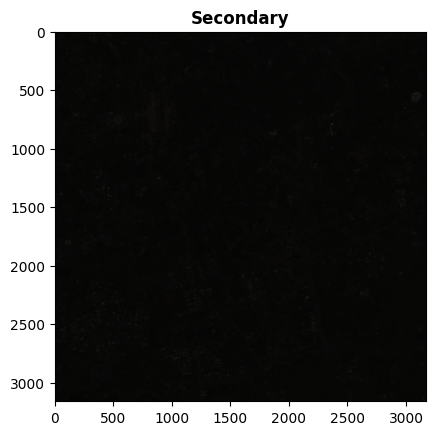

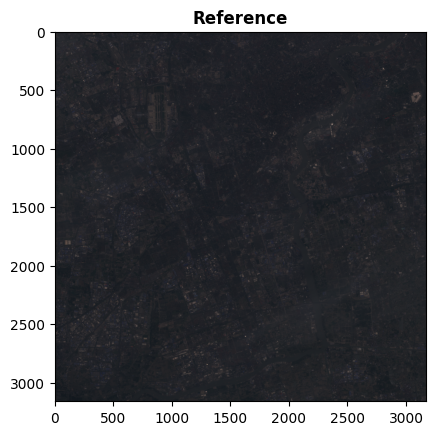

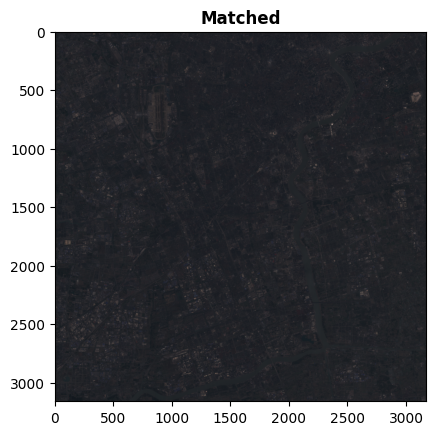

<Axes: title={'center': 'Matched'}>

In [6]:
# Plot a preview of the images
secondary_norm = (secondary - secondary.min()) / (secondary.max() - secondary.min())
show(secondary_norm, title="Secondary")

reference_norm = (reference - reference.min()) / (reference.max() - reference.min())
show(reference_norm, title="Reference")

with rio.open(secondary_matched_path, 'r+') as s:
    matched = s.read()

matched_norm = (matched - matched.min()) / (matched.max() - matched.min())
show(matched_norm, title="Matched")

C:\Users\andre\AppData\Local\Temp\ipykernel_15824\3222815993.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


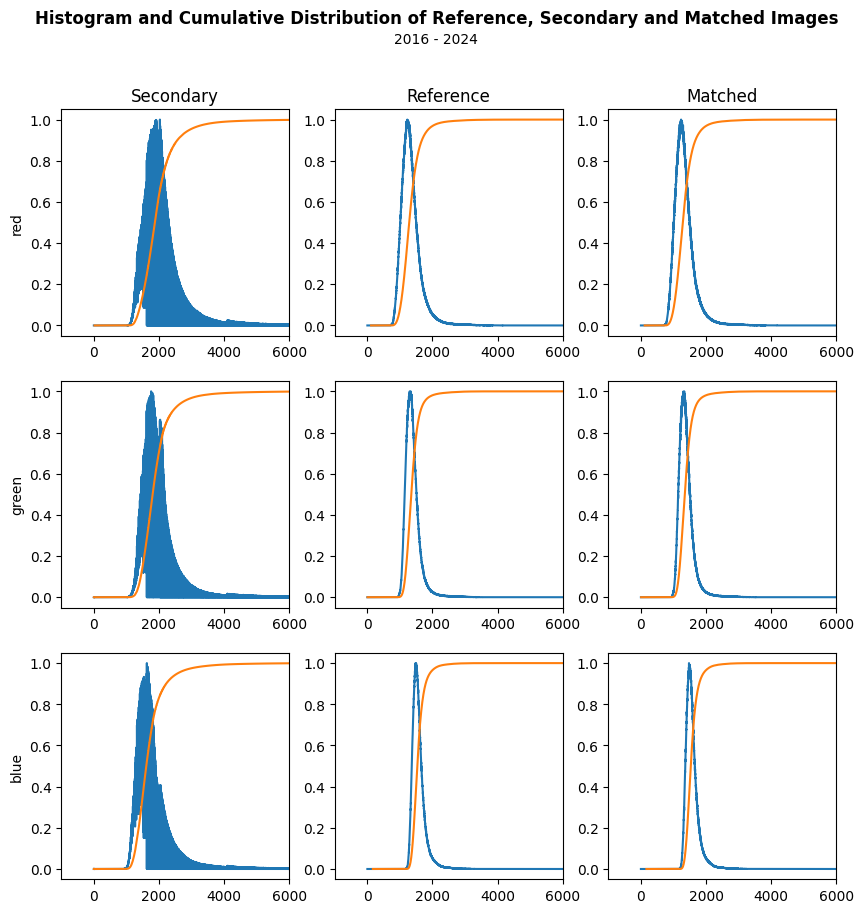

In [7]:
# plot histogram of master, slave and matched images

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))


for i, img in enumerate((secondary, reference, matched)):
    for c, c_color in enumerate(('red', 'green', 'blue')):
        img_hist, bins = exposure.histogram(img[c], source_range='dtype')
        axes[c, i].plot(bins, img_hist / img_hist.max())
        img_cdf, bins = exposure.cumulative_distribution(img[c])
        axes[c, i].plot(bins, img_cdf)
        axes[c, i].set_xlim([-1000, 6000])
        axes[c, 0].set_ylabel(c_color)

axes[0, 0].set_title('Secondary')
axes[0, 1].set_title('Reference')
axes[0, 2].set_title('Matched')

# Set a title for the entire plot
fig.suptitle('Histogram and Cumulative Distribution of Reference, Secondary and Matched Images', weight='bold')

# Add a subtitle below the main title
plt.text(0.5, 0.95, '2016 - 2024', ha='center', va='center', transform=fig.transFigure, fontsize=10)


plt.tight_layout()
plt.show()

# Save the plot to a file
output_plot_path = r"C:\Users\andre\OneDrive - Politecnico di Milano\Earth_observation\project\Mod_b\imgs_elab\histogram_match_comparative_histograms\histogram_16_24.png"
fig.savefig(output_plot_path)